# 4 Modeling<a id='4_Modeling'></a>

##### 4.1 Contents<a id='4.1_Contents'></a>
* [4 Modeling](#4_Modeling)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Introduction](#4.2_Introduction)
  * [4.3 Imports and Load Data](#4.3_Imports)
      * [4.3.1 Functions](#4.3.1_Functions) 
      * [4.3.2 Prediction with Q26 and Q27](#4.3.2_Q26_27) 
  * [4.4 Random Forests Classifier](#4.4_Random_Forests)
      * [4.4.1 Define X and y](#4.4.1_Xy)
      * [4.4.2 Hyperparameter Tuning - Randomized Search](#4.4.2_randomized_search)  
      * [4.4.3 Hyperparameter Tuning - Grid Search](#4.4.3_grid_search)
      * [4.4.4 Analysis of Final Model](#4.4.4_Analysis)
          * [4.4.4a Feature Importance](#4.4.4a_feature_importance)
          * [4.4.4b Precision Recall Curve and Area Under Curve](#4.4.4b_precision_recall_curve)
          * [4.4.4c Confusion Matrix](#4.4.4c_confusion_matrix)

  * [4.5 K-Means Clustering](#4.5_kmeans_clustering)
      * [4.5.1 Visualizing Clusters with PCA](#4.5.1_PCA)
  * [4.6 Characterizing Clusters](#4.6_characterize_clustering)
  * [4.7 PCA](#4.7_PCA) 
  * [4.8 Random Forest with PCA features](#4.8_PCA_RF) 
  * [4.9 Random Forest with X + cluster labels + PCA features](#4.9_RF_PCA_clusters)  
  * [4.10 Logistic Regression](#4.10_logistic_regression) 
  
  
   
      


## 4.2 Introduction<a id='4.2_Introduction'></a>

This notebook uses a Random Forests classifier to attempt to predict nonvoters from some of the survey responses. After that, K-Means is used clustering to attempt to cluster the voters into different types. Further refinements are attempted using principal component analysis and logistic regression.

## 4.3 Imports and Load Data<a id='4.3_Imports'></a>

In [238]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

In [239]:
# import Random Forests Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


In [240]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,log_loss
from matplotlib import pyplot


In [241]:
import itertools
from sklearn import svm, datasets

In [242]:
from sklearn.tree import export_graphviz
from subprocess import run
from IPython.display import Image

In [243]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [244]:
from sklearn.cluster import KMeans
import numpy as np

In [245]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

In [246]:
from sklearn.decomposition import PCA

Import file containing dummy variables.

In [247]:
df = pd.read_csv('Data/nonvoters_dummies.csv').drop(['Unnamed: 0'], axis=1)

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5836 entries, 0 to 5835
Columns: 313 entries, Q2_1_1 to Voter ID
dtypes: int64(313)
memory usage: 13.9 MB


In [249]:
df.head()

Q2_1_1  Q2_1_2  Q2_1_3  Q2_1_4  Q2_2_1  Q2_2_2  Q2_2_3  Q2_2_4  Q2_3_1  \
0       1       0       0       0       1       0       0       0       0   
1       1       0       0       0       0       1       0       0       0   
2       1       0       0       0       1       0       0       0       0   
3       1       0       0       0       1       0       0       0       1   
4       1       0       0       0       1       0       0       0       0   

   Q2_3_2  ...  income_cat_$75-125k  income_cat_Less than $40k  \
0       1  ...                    1                          0   
1       1  ...                    0                          0   
2       1  ...                    0                          0   
3       0  ...                    0                          0   
4       0  ...                    0                          0   

   voter_category_rarely/never  voter_category_sporadic  age_26-35  age_36-45  \
0                            0                        0          0          0   
1                            0                        0          0          0   
2                            0                        1          0          0   
3                            0                        1          0          0   
4                            0                        0          0          0   

   age_46-55  age_56-65  age_66+  Voter ID  
0          0          0        1    470001  
1          0          0        1    470002  
2          1          0        0    470003  
3          0          1        0    470007  
4          0          0        1    480008  

[5 rows x 313 columns]

In [250]:
df.shape

(5836, 313)

## 4.3.1 Functions <a id='4.3.1_Functions'></a> 

In [251]:
# takes a fit model and returns chart of most important features

def feature_importance(clf, X, size=30):
    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    importance_unsorted = pd.DataFrame({'feature':X.columns,'importance':feature_importance})
    importance_sorted = importance_unsorted.sort_values(by='importance',ascending=False)
    pos = np.arange(size) + .5
    plt.figure(figsize=(10,10))
    plt.barh(pos, importance_sorted['importance'][:size], align='center')
    plt.yticks(pos, importance_sorted['feature'][:size])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    return plt.show()

In [252]:
def split_data(df,test_size=0.2,random_state=42):
    X = df.drop(['voter_category_sporadic','voter_category_rarely/never'], axis=1)
    y = df['voter_category_rarely/never']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return (X, y, X_train, X_test, y_train, y_test) 

In [253]:
class_names = ['0','1']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [254]:
def print_tree(clf, X):
    estimator = clf.estimators_[5]
    # Export as dot file
    export_graphviz(estimator, out_file='tree.dot', 
                    feature_names = X.columns,
                    class_names = ['0','1'],
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)
    # Convert to png using system command (requires Graphviz)
    run(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
    # Display in jupyter notebook
    return Image(filename = 'tree.png')

In [255]:
def RF_model_results(clf, X_train, X_test, y_train, y_test):
    model_res = clf.fit(X_train, y_train)
    y_pred = model_res.predict(X_test)
    y_pred_prob = model_res.predict_proba(X_test)
    lr_probs = y_pred_prob[:,1]
    
    ac = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print('Random Forest: Test Accuracy=%.3f' % (ac))
    print('Random Forest: Test Precision=%.3f' % (prec))
    print('Random Forest: Test Recall=%.3f' % (rec))
    print(cm)
    y_pred_train = model_res.predict(X_train)
    train_ac = accuracy_score(y_train, y_pred_train)
    train_rec = recall_score(y_train, y_pred_train)
    train_prec = precision_score(y_train, y_pred_train)
    print('Random Forest: Train Accuracy=%.3f' % (train_ac))
    print('Random Forest: Train Precision=%.3f' % (train_prec))
    print('Random Forest: Train Recall=%.3f' % (train_rec))
    return (model_res, y_pred, y_pred_prob, lr_probs, ac, prec, rec, cm, train_ac, train_rec, train_prec)

### 4.3.2 Prediction with Q 26, 27<a id='4.3.2_Q26_27'></a> 

Check if questions 26 and 27 alone can accurately predict labels. They should since they ask explicitly how often they vote and which elections they voted in.

In [256]:
df_wrangled = pd.read_csv('Data/nonvoters_wrangled.csv').drop('Unnamed: 0',axis=1)
df_26_27 = df_wrangled[['Q26','Q27_1','Q27_2','Q27_3','Q27_4',
                       'Q27_5','Q27_6','voter_category']].astype(object)

In [257]:
df_26_27_dum = pd.get_dummies(df_26_27, drop_first=True)

In [258]:
X_27, y_27, X_train_27, X_test_27, y_train_27, y_test_27 = split_data(df_26_27_dum)

In [259]:
clf_27 = RandomForestClassifier(bootstrap=True, class_weight='balanced', 
    max_depth=None,
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=5, 
    n_estimators=500, random_state = 123, n_jobs=-1)

model_res_27, y_pred_27, y_pred_prob_27, lr_probs_27, ac_27, prec_27, rec_27, cm_27, train_ac_27, train_rec_27, train_prec_27 = RF_model_results(clf_27, X_train_27, X_test_27, y_train_27, y_test_27)

Random Forest: Test Accuracy=0.846
Random Forest: Test Precision=0.683
Random Forest: Test Recall=0.692
[[790  92]
 [ 88 198]]
Random Forest: Train Accuracy=0.870
Random Forest: Train Precision=0.733
Random Forest: Train Recall=0.751


The results are not as expected. Accuracy is not very high. Precision and recall are likewise poor.

In [260]:
#  Place voters who were misclassified and classified correctly in 
#  separate dataframes.

test_results = pd.concat([X_test_27,y_test_27], axis=1) 
test_results['prediction'] = y_pred_27
misclassified = test_results[test_results['voter_category_rarely/never']!=test_results['prediction']]
correct = test_results[test_results['voter_category_rarely/never']==test_results['prediction']]


In [261]:
misclassified.groupby('prediction').mean()

Q26_1     Q26_2     Q26_3     Q26_4   Q27_1_1   Q27_1_2  \
prediction                                                               
0           0.920455  0.079545  0.000000  0.000000  0.772727  0.215909   
1           0.489130  0.326087  0.086957  0.054348  0.402174  0.543478   

             Q27_2_1   Q27_2_2   Q27_3_1   Q27_3_2   Q27_4_1  Q27_4_2  \
prediction                                                              
0           0.931818  0.068182  0.625000  0.352273  0.852273  0.12500   
1           0.673913  0.271739  0.391304  0.554348  0.434783  0.51087   

             Q27_5_1   Q27_5_2   Q27_6_1   Q27_6_2  \
prediction                                           
0           0.511364  0.454545  0.647727  0.318182   
1           0.228261  0.717391  0.326087  0.619565   

            voter_category_rarely/never  
prediction                               
0                                   1.0  
1                                   0.0

In [262]:
correct.groupby('prediction').mean()

Q26_1     Q26_2     Q26_3     Q26_4   Q27_1_1   Q27_1_2  \
prediction                                                              
0           0.95443  0.041772  0.001266  0.001266  0.915190  0.082278   
1           0.10101  0.126263  0.297980  0.474747  0.121212  0.858586   

             Q27_2_1   Q27_2_2   Q27_3_1   Q27_3_2   Q27_4_1   Q27_4_2  \
prediction                                                               
0           0.987342  0.012658  0.843038  0.149367  0.963291  0.034177   
1           0.176768  0.797980  0.065657  0.914141  0.090909  0.888889   

             Q27_5_1   Q27_5_2   Q27_6_1   Q27_6_2  \
prediction                                           
0           0.807595  0.183544  0.921519  0.077215   
1           0.020202  0.959596  0.085859  0.893939   

            voter_category_rarely/never  
prediction                               
0                                   0.0  
1                                   1.0

Questions 26 and 27 do a decent job predicting voter category but the accuracy should be 100% (unless fivethirtyeight used some other basis for determining voter category that is not in the data).

Reassign voter_category for rows that are categorized incorrectly based on voter-reported voting history found in question 27.

First count and collect how many misassigned voters there are. Assign each voter a score based on how many times they have voted in recent elections.

In [263]:
df.head()

Q2_1_1  Q2_1_2  Q2_1_3  Q2_1_4  Q2_2_1  Q2_2_2  Q2_2_3  Q2_2_4  Q2_3_1  \
0       1       0       0       0       1       0       0       0       0   
1       1       0       0       0       0       1       0       0       0   
2       1       0       0       0       1       0       0       0       0   
3       1       0       0       0       1       0       0       0       1   
4       1       0       0       0       1       0       0       0       0   

   Q2_3_2  ...  income_cat_$75-125k  income_cat_Less than $40k  \
0       1  ...                    1                          0   
1       1  ...                    0                          0   
2       1  ...                    0                          0   
3       0  ...                    0                          0   
4       0  ...                    0                          0   

   voter_category_rarely/never  voter_category_sporadic  age_26-35  age_36-45  \
0                            0                        0          0          0   
1                            0                        0          0          0   
2                            0                        1          0          0   
3                            0                        1          0          0   
4                            0                        0          0          0   

   age_46-55  age_56-65  age_66+  Voter ID  
0          0          0        1    470001  
1          0          0        1    470002  
2          1          0        0    470003  
3          0          1        0    470007  
4          0          0        1    480008  

[5 rows x 313 columns]

In [264]:
# create a new dataframe that is a copy of df_wrangled, which does not
# have dummy variables.
# create another new dataframe called misassigned.

df_corr = df_wrangled.copy()
misassigned = pd.DataFrame(columns=['Cat','index','misclassified_as','score','age'])
len(misassigned)

0

In [265]:
# assign scores based on how many times a respondent voted.
df_corr['score']=0
for i in range(len(df_corr)):
    score = 0
    for col in ['Q27_1', 'Q27_2', 'Q27_3', 'Q27_4', 'Q27_5', 'Q27_6']:
        if df_corr.loc[i,col]==1:
            score += 1
    df_corr.loc[i,'score']=score

In [266]:
# preserve df as uncorrected dataframe with dummy variables
# create df_corr with same features but reassigns voter_category
df_corr_dum = df.copy()

In [267]:
# reassign certain respondents voter category
# changes are made to the df_corr_dum dataframe which contains dummy variables
# and the df_corr dataframe without dummy variables


count1, count2, count3, count4 = (0,0,0,0)
for i in range(len(df_corr)):  
    # if the 'score' is 0, they should be assigned 'rarely/never'
    if (df_corr.loc[i,'score']==0) & (df_corr.loc[i,'voter_category']!='rarely/never'):
        
        misassigned.loc[len(misassigned.index)] = [1, i, df_corr.loc[i,'voter_category'], df_corr.loc[i,'score'], df_corr.loc[i,'ppage']] 
        df_corr.loc[i,'voter_category']='rarely/never'
        df_corr_dum.loc[df_corr_dum['Voter ID']==df_corr.loc[i,'RespId'],['voter_category_rarely/never']]=1
        df_corr_dum.loc[df_corr_dum['Voter ID']==df_corr.loc[i,'RespId'],['voter_category_sporadic']]=0
        count1 += 1
    # if the score is 1 and the respondent is older than 22, they should
    # be assigned 'rarely/never'
    elif (df_corr.loc[i,'score']==1) & (df_corr.loc[i,'ppage']>22) & (df_corr.loc[i,'voter_category']!='rarely/never'):
        misassigned.loc[len(misassigned.index)] = [2, i, df_corr.loc[i,'voter_category'], df_corr.loc[i,'score'], df_corr.loc[i,'ppage']] 
        df_corr.loc[i,'voter_category']='rarely/never'
        df_corr_dum.loc[df_corr_dum['Voter ID']==df_corr.loc[i,'RespId'],['voter_category_rarely/never']]=1
        df_corr_dum.loc[df_corr_dum['Voter ID']==df_corr.loc[i,'RespId'],['voter_category_sporadic']]=0
        count2 += 1
    # if the score is between 3 and 5, they should not be assigned 'rarely/never'
    # reassign to 'sporadic'
    elif ((df_corr.loc[i,'score']>=3)&(df_corr.loc[i,'score']<=5)) & (df_corr.loc[i,'voter_category']=='rarely/never'):
        misassigned.loc[len(misassigned.index)] = [3, i, df_corr.loc[i,'voter_category'], df_corr.loc[i,'score'], df_corr.loc[i,'ppage']] 
        df_corr.loc[i,'voter_category']='sporadic'
        df_corr_dum.loc[df_corr_dum['Voter ID']==df_corr.loc[i,'RespId'],['voter_category_rarely/never']]=0
        df_corr_dum.loc[df_corr_dum['Voter ID']==df_corr.loc[i,'RespId'],['voter_category_sporadic']]=1
        count3 += 1
    # if the score is 6, they should be assigned 'always'
    elif (df_corr.loc[i,'score']==6) & (df_corr.loc[i,'voter_category']!='always'):
        misassigned.loc[len(misassigned.index)] = [4, i, df_corr.loc[i,'voter_category'], df_corr.loc[i,'score'], df_corr.loc[i,'ppage']] 
        df_corr.loc[i,'voter_category']='always'
        df_corr_dum.loc[df_corr_dum['Voter ID']==df_corr.loc[i,'RespId'],['voter_category_rarely/never']]=0
        df_corr_dum.loc[df_corr_dum['Voter ID']==df_corr.loc[i,'RespId'],['voter_category_sporadic']]=0
        count4 += 1
print(count1,count2,count3,count4)

79 88 265 1742


The counts outputed above show that the vast majority of misclassifications were respondents who voted in every election surveyed but weren't assigned 'always'

In [268]:
# a selection of misassigned respondents shows a variety of puzzling
# classifications
misassigned[misassigned['Cat']!=4].sample(10)

Cat index misclassified_as score age
803    3  2114     rarely/never     3  33
1210   3  3200     rarely/never     3  52
2146   2  5761         sporadic     1  55
262    3   725     rarely/never     3  24
1612   3  4338     rarely/never     3  27
1996   3  5398     rarely/never     5  29
24     3    72     rarely/never     3  27
1250   3  3316     rarely/never     3  26
2119   3  5693     rarely/never     3  25
2031   2  5481         sporadic     1  68

In [269]:
# show any voters with scores no greater than 1 classified as 'always'
df_corr[(df_corr['score']<=1) & (df_corr['voter_category']=='always')][['score','voter_category','ppage']]

score voter_category  ppage
1873      1         always     22
2587      1         always     22
3146      1         always     22
4318      1         always     22
4334      1         always     22
4361      1         always     22
4367      1         always     22
4375      1         always     22
4416      1         always     22
4429      1         always     22
4804      1         always     22
5574      1         always     22

12 voters aged 22 with a score of 1 assigned to 'Always.' It's a small number so I'll let it be.

In [270]:
# show any voters with scores over 2 classified as 'rarely/never'
df_corr[(df_corr['score']>2) & (df_corr['voter_category']=='rarely/never')][['score','voter_category','ppage']]

Empty DataFrame
Columns: [score, voter_category, ppage]
Index: []

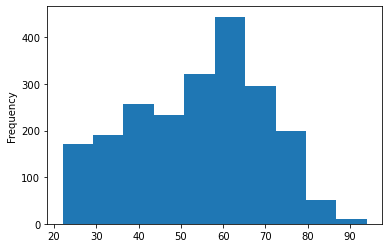

In [271]:
misassigned.age.plot(kind='hist')
plt.show()

Respondents are all ages are misassigned.

In [272]:
# create a dataframe to verify the integrity of the data
checkDF = pd.concat([df_corr[['ppage','RespId','voter_category','score']],df_corr_dum[['Voter ID','voter_category_rarely/never','voter_category_sporadic']]],axis=1)

In [273]:
# a sample of the data shows that the respondent id matches
# across dataframes and that voter_category is properly encoded with 
# the dummy variables
checkDF.sample(10)

ppage  RespId voter_category  score  Voter ID  \
5694     55  477494         always      6    477494   
4400     27  475783         always      4    475783   
2178     54  472897         always      6    472897   
4010     67  475282         always      5    475282   
3845     28  475083       sporadic      4    475083   
5510     44  477252       sporadic      3    477252   
4238     64  485969         always      6    485969   
2072     64  472754         always      6    472754   
3739     62  474956   rarely/never      1    474956   
3532     37  474701       sporadic      4    474701   

      voter_category_rarely/never  voter_category_sporadic  
5694                            0                        0  
4400                            0                        0  
2178                            0                        0  
4010                            0                        0  
3845                            0                        1  
5510                            0                        1  
4238                            0                        0  
2072                            0                        0  
3739                            1                        0  
3532                            0                        1

In [274]:
df_26_27['voter_category'].value_counts()

sporadic        2574
always          1811
rarely/never    1451
Name: voter_category, dtype: int64

In [275]:
checkDF['voter_category'].value_counts()

always          3497
rarely/never    1171
sporadic        1168
Name: voter_category, dtype: int64

The value counts above show that with reclassification, the number of 'sporadic' voters decreased considerably, 'always' voters increased considerably, and 'rarely/never' voters decreased a bit.

In [276]:
df_corr_dum.shape

(5836, 313)

In [277]:
# drop features related to questions 26 and 27 
# because they are too closely related to frequency of voting

drop_columns = []
for col in df_corr_dum.columns:
    if 'Q27_' in col or 'Q26_' in col:
        drop_columns.append(col)
print(drop_columns)        

['Q26_1', 'Q26_2', 'Q26_3', 'Q26_4', 'Q27_1_1', 'Q27_1_2', 'Q27_2_1', 'Q27_2_2', 'Q27_3_1', 'Q27_3_2', 'Q27_4_1', 'Q27_4_2', 'Q27_5_1', 'Q27_5_2', 'Q27_6_1', 'Q27_6_2']


In [278]:
df_corr_dum = df_corr_dum.drop('Voter ID',axis=1)
df_corr_dum = df_corr_dum.drop(drop_columns,axis=1)

In [279]:
df_corr_dum.shape

(5836, 296)

In [280]:
df_corr_dum.head()

Q2_1_1  Q2_1_2  Q2_1_3  Q2_1_4  Q2_2_1  Q2_2_2  Q2_2_3  Q2_2_4  Q2_3_1  \
0       1       0       0       0       1       0       0       0       0   
1       1       0       0       0       0       1       0       0       0   
2       1       0       0       0       1       0       0       0       0   
3       1       0       0       0       1       0       0       0       1   
4       1       0       0       0       1       0       0       0       0   

   Q2_3_2  ...  income_cat_$40-75k  income_cat_$75-125k  \
0       1  ...                   0                    1   
1       1  ...                   0                    0   
2       1  ...                   0                    0   
3       0  ...                   1                    0   
4       0  ...                   1                    0   

   income_cat_Less than $40k  voter_category_rarely/never  \
0                          0                            0   
1                          0                            0   
2                          0                            0   
3                          0                            0   
4                          0                            0   

   voter_category_sporadic  age_26-35  age_36-45  age_46-55  age_56-65  \
0                        0          0          0          0          0   
1                        0          0          0          0          0   
2                        0          0          0          1          0   
3                        0          0          0          0          1   
4                        0          0          0          0          0   

   age_66+  
0        1  
1        1  
2        0  
3        0  
4        1  

[5 rows x 296 columns]

## 4.4 Random Forests Classifier<a id='4.4_Random_Forests'></a>

## 4.4.1 Define X and y<a id='4.4.1_Xy'></a> 

X and y are generated below. df_corr is data that removes Voter Id, weight and recategorizes some of the voters based on their answers to question 27 which asks which elections they voted in.

In [281]:
# define df for modeling
dataframe = df_corr_dum

# Split dataframe to X, y--train and test.

X, y, X_train, X_test, y_train, y_test = split_data(dataframe)

In [282]:
# run Random Forest classifier with corrected data

clf = RandomForestClassifier(
    bootstrap=False, 
    class_weight='balanced_subsample', 
    max_depth=5,
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=5, 
    n_estimators=300, random_state = 123, n_jobs=-1)

model_res, y_pred, y_pred_prob, lr_probs, ac, prec, rec, cm, train_ac, train_rec, train_prec = RF_model_results(clf, X_train, X_test, y_train, y_test)

Random Forest: Test Accuracy=0.895
Random Forest: Test Precision=0.729
Random Forest: Test Recall=0.726
[[881  61]
 [ 62 164]]
Random Forest: Train Accuracy=0.899
Random Forest: Train Precision=0.747
Random Forest: Train Recall=0.758


With 'uncorrected' dummy data with all features:

Random Forest: Test Accuracy=0.854  
Random Forest: Test Precision=0.694  
Random Forest: Test Recall=0.720  
791  91    
80   206   
Random Forest: Train Accuracy=0.864  
Random Forest: Train Precision=0.712  
Random Forest: Train Recall=0.762 

With 'corrected dummy data with all features (except questions 26_ & 27_):  

Random Forest: Test Accuracy=0.894  
Random Forest: Test Precision=0.724  
Random Forest: Test Recall=0.730  
879  63  
 61 165  
Random Forest: Train Accuracy=0.899  
Random Forest: Train Precision=0.742  
Random Forest: Train Recall=0.771     

Performance improves by 'correcting' the target variable, so df_corr_dum will be used from now on.

## 4.4.2 Hyperparameter Tuning - Randomized Search<a id='4.4.2_randomized_search'></a> 

In [283]:
X_train.shape, X_test.shape

((4668, 294), (1168, 294))

In [284]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(20, 320, 11)]
# Number of features to consider at every split
max_features = ['sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 43, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Method of class balance
class_weight=['balanced','balanced_subsample',None]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight':class_weight}

In [285]:
run_tuning = False

In [286]:
# check if tuning needs to run
if run_tuning:
    # Use the random grid to search for best hyperparameters
    rf = RandomForestClassifier()
    # Random search of parameters, using 5 fold cross validation, 
    # search across 200 different combinations
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='recall', n_iter = 200, cv = 5, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train,y_train)
    rf_random.best_params_

Corrected voter_category (-Q26 -Q27) Score by ROC-AUC
{'n_estimators': 230,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 15,
 'class_weight': 'balanced_subsample,
 'bootstrap': False}

Corrected voter_category (-Q27) Score by ROC-AUC
{'n_estimators': 170,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 27,
 'class_weight': 'balanced_subsample,
 'bootstrap': True}
 
 Score by Recall:  
 {'n_estimators': 110,  
 'min_samples_split': 50,  
 'min_samples_leaf': 1,  
 'max_features': 'sqrt',  
 'max_depth': 27,  
 'class_weight': 'balanced',  
 'bootstrap': False}  
 
 

In [287]:
#  RS_scores = pd.DataFrame(rf_random.cv_results_)

In [288]:
#  RS_scores.head()

In [289]:
# from sklearn.metrics import SCORERS
# sorted(SCORERS.keys())

## 4.4.3 Hyperparameter Tuning - Grid Search<a id='4.4.3_grid_search'></a> 

Randomized Turning results:
{'n_estimators': 230,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 15,
 'class_weight': 'balanced_subsample',
 'bootstrap': False}

In [290]:
# Minimum number of samples required to split a node
min_samples_split = [2,10,50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,5]
# Maximum number of features in one tree
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [5,25]
# Class weight
class_weight = ['balanced',None]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the grid
param_grid = { 'min_samples_split': min_samples_split,
                # 'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
               'max_depth': max_depth,
               'class_weight': class_weight,
               'bootstrap': bootstrap}

In [291]:
# check if tuning needs to run

if run_tuning:

    # add parameters to grid
    rf = RandomForestClassifier(n_estimators=200)
    rf_cv= GridSearchCV(rf,param_grid,cv=5,scoring='recall')
    rf_cv.fit(X_train,y_train)
    print("Best Score:" + str(rf_cv.best_score_))
    print("Best Parameters: " + str(rf_cv.best_params_))

Scorer: ROC-AUC
{'bootstrap': False,   
'class_weight': 'balanced_subsample',   
'max_depth': 15,   
'max_features': 'sqrt'  
'min_samples_leaf': 2,   
'min_samples_split': 5}  

Scorer: Recall  
{'bootstrap': False,   
'class_weight': 'balanced',   
'max_depth': 25,   
'min_samples_leaf': 1,   
'min_samples_split': 50}  

Run tuned model on test data

In [292]:
# Run model with tuned hyperparameters

clf = RandomForestClassifier(
    bootstrap=False, 
    class_weight='balanced', 
    max_depth=25,
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=50, 
    n_estimators=200, random_state = 42, n_jobs=-1)

RF_model_results(clf, X_train, X_test, y_train, y_test)


Random Forest: Test Accuracy=0.904
Random Forest: Test Precision=0.739
Random Forest: Test Recall=0.779
[[880  62]
 [ 50 176]]
Random Forest: Train Accuracy=0.938
Random Forest: Train Precision=0.804
Random Forest: Train Recall=0.920


(RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=25,
                        max_features='sqrt', min_samples_split=50,
                        n_estimators=200, n_jobs=-1, random_state=42),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([[0.72, 0.28],
        [0.7 , 0.3 ],
        [0.55, 0.45],
        ...,
        [0.88, 0.12],
        [0.95, 0.05],
        [0.86, 0.14]]),
 array([0.28, 0.3 , 0.45, ..., 0.12, 0.05, 0.14]),
 0.9041095890410958,
 0.7394957983193278,
 0.7787610619469026,
 array([[880,  62],
        [ 50, 176]], dtype=int64),
 0.9383033419023136,
 0.9195767195767196,
 0.8038852913968547)

ROC-AUC optimized parameters:  
Random Forest: Test Accuracy=0.920  
Random Forest: Test Precision=0.867  
Random Forest: Test Recall=0.695  
[[918  24]  
 [ 69 157]]  
Random Forest: Train Accuracy=0.997  
Random Forest: Train Precision=0.993  
Random Forest: Train Recall=0.994  

Recall optimized parameters:  

Random Forest: Test Accuracy=0.904  
Random Forest: Test Precision=0.739  
Random Forest: Test Recall=0.779  
[[880  62]  
 [ 50 176]]  
Random Forest: Train Accuracy=0.938  
Random Forest: Train Precision=0.804  
Random Forest: Train Recall=0.920  


Using the model developed with hyperparameter tuning results in a great deal of overfitting.

Try running the model again but with a maximum tree depth of 5 (instead of None).

In [293]:
# Run model with tuned hyperparameters

clf = RandomForestClassifier(
    bootstrap=False,
    class_weight='balanced', 
    max_depth=5,
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=50, 
    n_estimators=200, random_state = 42, n_jobs=-1
    )

RF_model_results(clf, X_train, X_test, y_train, y_test)


Random Forest: Test Accuracy=0.897
Random Forest: Test Precision=0.732
Random Forest: Test Recall=0.739
[[881  61]
 [ 59 167]]
Random Forest: Train Accuracy=0.897
Random Forest: Train Precision=0.735
Random Forest: Train Recall=0.770


(RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=5,
                        max_features='sqrt', min_samples_split=50,
                        n_estimators=200, n_jobs=-1, random_state=42),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([[0.68, 0.32],
        [0.68, 0.32],
        [0.58, 0.42],
        ...,
        [0.73, 0.27],
        [0.81, 0.19],
        [0.77, 0.23]]),
 array([0.32, 0.32, 0.42, ..., 0.27, 0.19, 0.23]),
 0.8972602739726028,
 0.7324561403508771,
 0.7389380530973452,
 array([[881,  61],
        [ 59, 167]], dtype=int64),
 0.8973864610111397,
 0.7703703703703704,
 0.7353535353535353)

ROC-AUC scored optimized parameters (with max depth 5):  
Random Forest: Test Accuracy=0.896  
Random Forest: Test Precision=0.728  
Random Forest: Test Recall=0.735  
[[880  62]  
 [ 60 166]]  
Random Forest: Train Accuracy=0.903  
Random Forest: Train Precision=0.755  
Random Forest: Train Recall=0.775  

Recall scored optimized parameters (with max depth 5):  

Random Forest: Test Accuracy=0.897  
Random Forest: Test Precision=0.732  
Random Forest: Test Recall=0.739  
[[881  61]  
 [ 59 167]]  
Random Forest: Train Accuracy=0.897  
Random Forest: Train Precision=0.735  
Random Forest: Train Recall=0.770  

This change in max tree depth improves the fitting. As expected, the performance metric go down, but the testing performance is more similar to the training performance indicating overfitting has been largely eliminated.

Final parameters:  
    
bootstrap=False,   
class_weight='balanced',   
max_depth=5,  
max_features='sqrt',   
min_samples_leaf=1,   
min_samples_split=50  

In [294]:
print_tree(clf, X)

## 4.4.4 Analysis of Final Model<a id='4.4.4_Analysis'></a> 

## 4.4.4a Feature Importance<a id='4.4.4a_feature_importance'></a> 

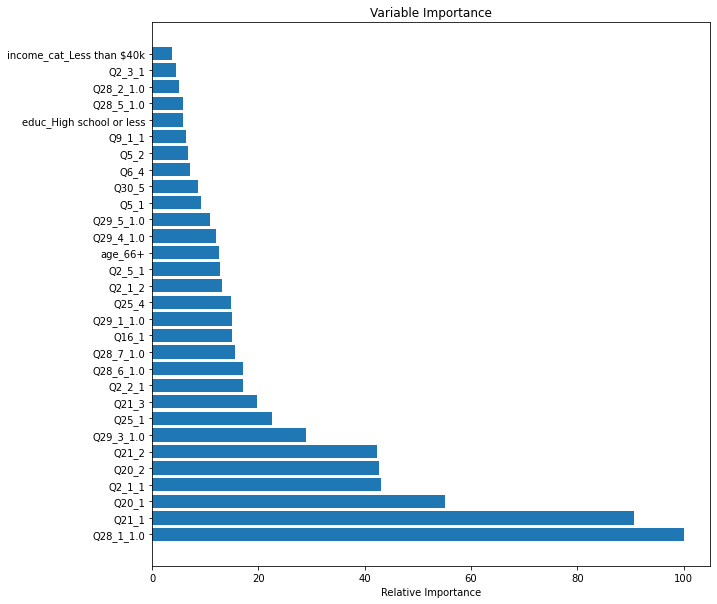

In [295]:
feature_importance(clf, X_test, size=30)

ROC-AUC tuned top features:
28_1_1.0, 21_1, 2_1_1, 20_1, 20_2, 29_3_1.0

Recall tuned top features:
28_1_1.0, 21_1, 20_1, 2_1_1,  20_2, 21_2, 29_3_1.0


According to the model, question 26 is the most important feature (when answering 1). Question 26 asks how often respondent votes. Answer 1 is 'always'. It is not surprising that this feature would be relevant. The fifth most important features is 26_4. Answer 4 is 'I don't vote'. Answer 3 -- the 8th most important feature -- is 'I rarely vote'.

The second most important features is Q28_1_1.0. Question 28 asks what factors caused respondent to vote. Choice 1 is that voting is an important civic duty.

Question 21 asks if respondent plans to vote in 2020 national election. Answer 1 is 'yes'.

Question 2 asks how important a factor is in being a good American. Choice 1 is voting in elections.

Question 20 asks if the respondent are currently registered to vote. Answer 2 is 'no'; 1 is 'yes'.

These results suggest that citizens who believe that voting is a civic duty are most likely to vote. Being registered to vote is also a good predictor, but that does not mean that registering reluctant voters will make them more likely to vote.

In [296]:
# print table of most important features
# show percentage of respondents within voter_category
# who answered affirmatively for question (field is '1')

most_important_features = ['Q28_1_1.0','Q21_1','Q2_1_1','Q20_2','Q20_1','Q29_3_1.0','voter_category_rarely/never']
best_features = df_corr_dum[most_important_features]
best_features.groupby('voter_category_rarely/never').mean()

Q28_1_1.0    Q21_1    Q2_1_1     Q20_2     Q20_1  \
voter_category_rarely/never                                                     
0                             0.817149  0.95477  0.911468  0.005145  0.993355   
1                             0.205807  0.41930  0.432109  0.394535  0.594364   

                             Q29_3_1.0  
voter_category_rarely/never             
0                             0.018650  
1                             0.269855

## 4.4.4b Precision Recall Curve and Area Under Curve<a id='4.4.4b_precision_recall_curve'></a> 

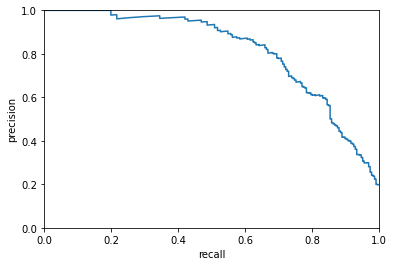

In [297]:
# precision recall curve

pred_prob_1 = []
for i in range(len(y_pred_prob)):
    pred_prob_1.append(y_pred_prob[i][1])
pred_prob_1 = np.array(pred_prob_1)
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob_1, pos_label=1)
_ = plt.plot(recall, precision)
_ = plt.xlabel('recall')
_ = plt.ylabel('precision')
_ = plt.xlim((0,1))
_ = plt.ylim((0,1))
plt.show()

In [298]:
# Calculate AUC -- area under precision-recall curve
PR = sorted(list(zip(precision,recall)))
precision,recall = zip(*PR)
auc(precision, recall)

0.6160160947569622

## 4.4.4c Confusion Matrix<a id='4.4.4c_confusion_matrix'></a> 

Confusion matrix, without normalization
[[881  61]
 [ 62 164]]
Normalized confusion matrix
[[0.94 0.06]
 [0.27 0.73]]


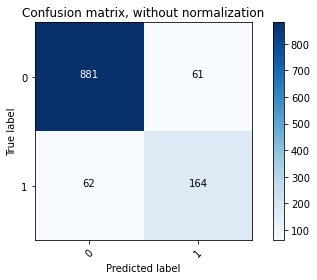

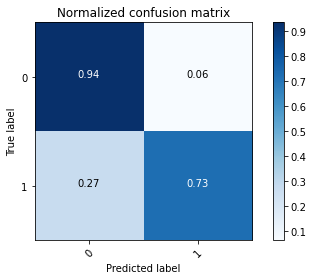

In [299]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

## 4.5 K-Means Clustering<a id='4.5_kmeans_clustering'></a> 

In [300]:
X.columns

Index(['Q2_1_1', 'Q2_1_2', 'Q2_1_3', 'Q2_1_4', 'Q2_2_1', 'Q2_2_2', 'Q2_2_3',
       'Q2_2_4', 'Q2_3_1', 'Q2_3_2',
       ...
       'race_White', 'gender_Male', 'income_cat_$40-75k',
       'income_cat_$75-125k', 'income_cat_Less than $40k', 'age_26-35',
       'age_36-45', 'age_46-55', 'age_56-65', 'age_66+'],
      dtype='object', length=294)

In [301]:
X.shape

(5836, 294)

In [302]:
X_top8 = X[['Q2_1_1','Q2_2_1','Q2_1_2','Q2_3_1','Q2_5_1','Q2_2_3','Q2_1_1','Q2_7_1']]
X_top5 = X[['Q2_1_1','Q2_2_1','Q2_1_2','Q2_3_1','Q2_5_1']]
X_best = X[['Q2_1_2', 'Q2_1_3', 'Q2_1_4', 'Q2_2_4', 'Q2_3_3', 'Q2_3_4', 'Q2_5_3', 'Q9_1_3', 'Q30_5']]
X_best2 = X[['Q2_1_3', 'Q2_1_4', 'Q2_3_4', 'Q2_5_3', 'Q9_1_3', 'Q30_5']]


In [303]:
x_cols = X.to_numpy()
x_cols

array([[1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [304]:
ss_means = []
k_list = []
for k in range(3,10): 
    ss = []
    k_list.append(k)
    for run in range(3):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit_predict(x_cols)
        ss.append(kmeans.inertia_)
    ss_means.append(np.mean(ss))
print(k_list,ss_means)

[3, 4, 5, 6, 7, 8, 9] [223855.99312479713, 220667.58183739358, 217934.00582484528, 216162.6985926895, 214632.39903445158, 213259.171334344, 212054.85380840467]


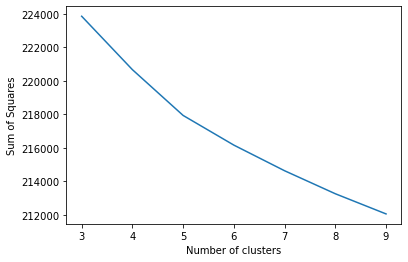

In [305]:
_ = plt.plot(k_list,ss_means)
_ = plt.xlabel('Number of clusters')
_ = plt.ylabel('Sum of Squares')
plt.show()

In [306]:
kmeans = KMeans(n_clusters=5)
kmeans.fit_predict(x_cols)

array([4, 3, 3, ..., 1, 0, 1])

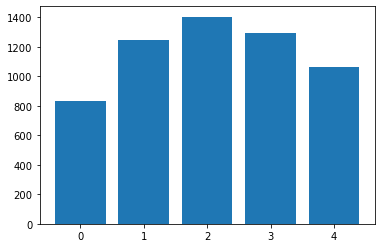

In [307]:
labels = kmeans.labels_
unique, counts = np.unique(labels, return_counts=True)
_ = plt.bar(unique, counts)
plt.show()

In [308]:
type(labels)

numpy.ndarray

In [309]:
silhouette_score(x_cols, labels)

0.03273175215684303

In [310]:
dic = dict() 

for i in range(5):
    kmeans = KMeans(n_clusters=5)
    kmeans.fit_predict(x_cols)
    dic['labels_'+str(i)] = kmeans.labels_
labels_df = pd.DataFrame(dic)
labels_df.head()

labels_0  labels_1  labels_2  labels_3  labels_4
0         2         1         1         1         4
1         1         4         4         0         2
2         1         4         4         0         2
3         4         0         3         2         1
4         3         3         0         3         3

In [311]:
labels_grouped = labels_df.groupby('labels_0').mean()
print(labels_grouped)

          labels_1  labels_2  labels_3  labels_4
labels_0                                        
0         2.016260  2.046458  3.836237  0.037166
1         3.982267  3.959907  0.083269  2.006168
2         0.993476  1.042870  1.049394  3.980429
3         3.000000  0.012978  2.983417  2.991348
4         0.004105  2.995895  1.998358  1.012315


In [312]:
l = len(labels_grouped)

In [313]:
labels = list(labels_grouped.columns[0:l-1])
print(labels)

['labels_1', 'labels_2', 'labels_3', 'labels_4']


In [314]:
#'labels_1':{4:0,3:1,0:2,1:3,2:4}

labels_dict = dict()
for label in labels:
    labels_dict[label] = dict()
    for j in range(l):
        labels_dict[label][int(round(labels_grouped.loc[j,label]))] = j
print(labels_dict)
        
        
        #int(labels_grouped.loc[1,'labels_1'])

{'labels_1': {2: 0, 4: 1, 1: 2, 3: 3, 0: 4}, 'labels_2': {2: 0, 4: 1, 1: 2, 0: 3, 3: 4}, 'labels_3': {4: 0, 0: 1, 1: 2, 3: 3, 2: 4}, 'labels_4': {0: 0, 2: 1, 4: 2, 3: 3, 1: 4}}


In [315]:
labels_df.replace(labels_dict,inplace=True)

# labels should now be consistent with each other
labels_df.groupby('labels_0').mean()

labels_1  labels_2  labels_3  labels_4
labels_0                                        
0         0.019744  0.051103  0.049942  0.018583
1         1.008481  1.065536  1.111796  1.008481
2         2.013048  2.042870  2.094129  2.013048
3         2.992790  2.992069  2.984859  2.990627
4         3.991790  3.997537  3.977011  3.991790

In [316]:
labels_df['mean'] = labels_df.mean(axis=1)

In [317]:
# count how many rows are classified with more than 1 label 
# in the 5 runs

count = 0
indexes = []
for i in range(len(labels_df)):
    if (labels_df.loc[i,'mean']- round(labels_df.loc[i,'mean'])) != 0:
        count += 1
        indexes.append(i)
print(count)
nonuniform_labels = labels_df.iloc[indexes,:]
print(type(nonuniform_labels))
nonuniform_labels.head()

185
<class 'pandas.core.frame.DataFrame'>


labels_0  labels_1  labels_2  labels_3  labels_4  mean
18         3         3         3         4         3   3.2
61         1         1         3         3         1   1.8
75         0         0         3         0         0   0.6
76         2         2         4         4         2   2.8
89         1         1         4         4         1   2.2

Only 172 rows (~2%) received more than 1 label. This is fairly consistent labeling.

In [318]:
# check how many rows have more than 2 labels

T = nonuniform_labels.drop('mean',axis=1).T
for col in T:
    if len(T[col].unique())>2:
           print(T[col])

No rows have more than 2 labels.

## 4.5.1 Visualizing Clusters with PCA<a id='4.5.1_PCA'></a> 

In [319]:
# translate voter_category to numerical voter_code
# add column to df_corr
voter_code = {'rarely/never':2,'sporadic':1,'always':0}
for i in range(len(df_corr)):
    df_corr.loc[i,'voter code'] = voter_code[df_corr.loc[i,'voter_category']]

In [320]:
# choose number of components for PCA
n_components = 2
# choose number of cluster for K-Means clustering
n_clusters = 5

In [321]:
# choose dataframe subslice to convert to numpy array
x_cols = X.to_numpy()

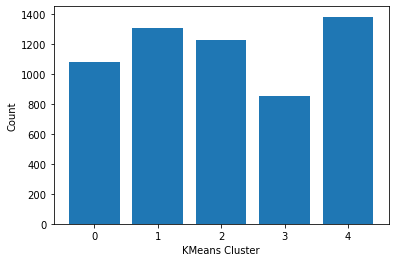

In [322]:
# cluster x_cols with KMeans using n_clusters specified above

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit_predict(x_cols)
labels = kmeans.labels_
unique, counts = np.unique(labels, return_counts=True)

# perform PCA on df_corr_dum 

pca = PCA(n_components=n_components)
pca.fit(df_corr_dum)
pca_data = pca.transform(df_corr_dum)

# create dataframe with first two pca components, labels, voter category
pca_df = pd.DataFrame({'x':pca_data[:,0],'y':pca_data[:,1]
                       ,'kmeans label':labels,'voter category':df_corr['voter_category']
                      ,'voter code':df_corr['voter code']})

_ = plt.bar(unique, counts)
_ = plt.xlabel('KMeans Cluster')
_ = plt.ylabel('Count')
plt.show()

In [323]:
# add labels from clustering to new DataFrame.
# make a summary DataFrame that groups and aggregates data by label.

df_labels = df_corr_dum.copy()
df_labels['labels']=labels
df_summary = df_labels.groupby('labels').mean()
df_summary['voter_category_always'] = 1-df_summary['voter_category_rarely/never']-df_summary['voter_category_sporadic']
df_summary

Q2_1_1    Q2_1_2    Q2_1_3    Q2_1_4    Q2_2_1    Q2_2_2    Q2_2_3  \
labels                                                                         
0       0.904453  0.080705  0.008349  0.004638  0.396104  0.458256  0.109462   
1       0.799080  0.184049  0.013037  0.000767  0.384969  0.475460  0.115031   
2       0.976288  0.013900  0.002453  0.003271  0.721995  0.206868  0.048242   
3       0.272941  0.402353  0.131765  0.171765  0.136471  0.372941  0.278824   
4       0.952209  0.037654  0.002896  0.002896  0.639392  0.278059  0.057929   

          Q2_2_4    Q2_3_1    Q2_3_2  ...  income_cat_$75-125k  \
labels                                ...                        
0       0.036178  0.446197  0.498145  ...             0.320965   
1       0.019172  0.261503  0.644939  ...             0.300613   
2       0.016353  0.775143  0.197874  ...             0.274734   
3       0.196471  0.136471  0.430588  ...             0.167059   
4       0.018827  0.641564  0.313541  ...             0.298335   

        income_cat_Less than $40k  voter_category_rarely/never  \
labels                                                           
0                        0.150278                     0.120594   
1                        0.223160                     0.194018   
2                        0.252657                     0.051513   
3                        0.482353                     0.710588   
4                        0.178132                     0.087618   

        voter_category_sporadic  age_26-35  age_36-45  age_46-55  age_56-65  \
labels                                                                        
0                      0.289425   0.366419   0.189239   0.121521   0.144712   
1                      0.284509   0.142638   0.174847   0.185583   0.232362   
2                      0.125102   0.053148   0.067866   0.135732   0.286182   
3                      0.158824   0.348235   0.218824   0.136471   0.147059   
4                      0.142650   0.097031   0.104996   0.170167   0.248371   

         age_66+  voter_category_always  
labels                                   
0       0.081633               0.589981  
1       0.214724               0.521472  
2       0.443990               0.823385  
3       0.065882               0.130588  
4       0.345402               0.769732  

[5 rows x 297 columns]

In [324]:
#cluster_summary = pd.DataFrame(columns=['Question','Cluster','',''])
question=[]
cluster=[]
strength_over_mean=[]
strength_over_2=[]
for col in df_summary.columns:
    if df_summary[col].max()/df_summary[col].mean()>1.5:
        question.append(col)
        cluster.append(df_summary[col].idxmax())
        strength_over_mean.append(df_summary[col].max()/df_summary[col].mean())     
        strength_over_2.append(df_summary[col].max()/df_summary[col].quantile(0.75))     

# create summary dataframe from lists 
cluster_summary=pd.DataFrame({'Question':question,'Cluster':cluster,
                              'Strength Over Mean':strength_over_mean,
                              'Strength Over 2nd Best':strength_over_2})

In [325]:
len(cluster_summary), len(df_corr_dum.columns)

(196, 296)

## 4.6 Characterizing Clusters<a id='4.6_characterize_clustering'></a> 


The following tables show the most important features for each cluster

In [326]:
for cluster in [0,1,2,3,4]:
    print(cluster_summary[cluster_summary['Cluster']==cluster].sort_values('Strength Over 2nd Best',ascending=False).head(5))

     Question  Cluster  Strength Over Mean  Strength Over 2nd Best
27     Q2_9_4        0            2.682349                2.986235
13     Q2_4_4        0            2.830045                2.311113
138   Q18_6_1        0            2.044710                2.025908
22     Q2_7_3        0            2.865651                1.929002
142  Q18_10_1        0            1.742185                1.874871
    Question  Cluster  Strength Over Mean  Strength Over 2nd Best
31    Q3_1_2        1            2.099199                1.684301
35    Q3_2_3        1            1.890477                1.491157
165    Q25_2        1            1.671386                1.469666
112    Q14_2        1            1.713492                1.461269
185  Q31_2.0        1            2.257818                1.413731
    Question  Cluster  Strength Over Mean  Strength Over 2nd Best
83    Q8_7_1        2            3.184032                3.923826
42    Q3_4_4        2            3.054467                3.070508
81  

NONVOTERS    
Cluster 0 is formed primarily from questions:


Q2_1_4      Voting in elections -- not at all important  
Q29_9_1.0   I don’t believe in voting  
Q2_3_4      Following what happens in government and politics -- not at               all important  
Q22_2.0     I don’t trust the political system to serve my needs  
Q21_2       No do not plan to vote in November, 2020 election  

Never vote - 72%       

DIFFICULTY VOTING/LOW ENTHUSIASM  
Cluster 1 is formed primarily from questions:  

Q2_9_4  Believing in God -- not at all important  
Q2_4_4  Displaying the American flag -- not at all important  
Q18_6_1 Had to cast a provisional ballot  
Q2_7_3  Supporting the military -- not so important  
Q18_7_1 Couldn’t get off work to vote when polls were open 

Always vote - 59%, Sporadic - 29%  

TRUSTING IN INSTITUTIONS  
Cluster 2 is formed primarily from questions:    

Q8_7_1  Trust the news media -- a lot         
Q3_4_4  The mainstream media is more interested in making money than   telling the truth -- strongly disagree        
Q17_4_1 Electronic votes submitted online or by email safe/secure -- very confident          
Q8_6_1  Trust the intelligence community -- a lot       
Q8_2_1  Trust Congress -- a lot  

Always vote - 82%

STRONG REPUBLICAN/SKEPTICAL OF RACISM    
Cluster 3 is formed primarily from questions:    

Q8_1_1  Trust the presidency - a lot  
Q15_5   The Democratic Party does not want people like me to vote, and works hard to keep us from being able to vote  
Q31_1.0 Strong Republican   
Q3_2_4 Systemic racism in policing is a bigger problem than violence and vandalism in protests - Strongly disagree   
Q3_1_4 Systemic racism is a problem in the United States - Strongly disagree  

Always vote - 77%

WEAK REPUBLICAN  
Cluster 4 is formed primarily from questions:    

Q3_1_2 Systemic racism is a problem in the United States - Somewhat agree   
Q3_2_3 Systemic racism in policing is a bigger problem than violence and vandalism in protests - Somewhat disagree    
Q25_2  Following the 2020 presidential race -- somewhat closely  
Q14_2  The Republican Party wants people like me to vote but does not work hard to earn our votes  
Q31_2.0  Not very strong Republican  
  
Always vote - 51%, Sporadic - 29%  

In [327]:
pca.explained_variance_ratio_


array([0.07, 0.05])

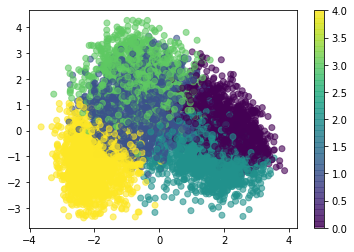

In [328]:
plt.scatter(pca_df['x'],pca_df['y'],c=pca_df['kmeans label'],alpha=.6)
plt.colorbar()
plt.show()

The clusters are quite clear! 

Based on the strength of the top five features (see table), the clusters 0, 2, and 3 should be the strongest (with cluster 4 very weak). The figure above lends some support to that assertion, though there is significant overlap with all clusters.

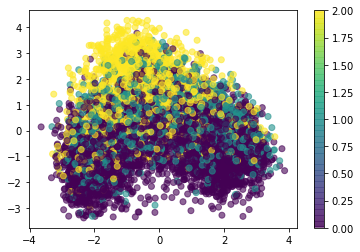

In [329]:
plt.scatter(pca_df['x'],pca_df['y'],c=pca_df['voter code'],alpha=.6)
plt.colorbar()
plt.show()

'rarely/never' -- 2,'sporadic' -- 1,'always' -- 0  

The first two principal components separate the voter_categories fairly nicely. We see a clear gradient with 'rarely/never' voters at the top in yellow and 'always' voters at the bottom.  

As noted above in the cluster descriptions, clusters 2 and 3 are the strongest voters.

## 4.7 PCA<a id='4.7_PCA'></a>

Perform PCA on dataframe with dummy variables (with drops)

In [330]:
X_train.shape

(4668, 294)

In [331]:
# confirm that questions 26 and 27 are not in the X_train columns

for col in X_train.columns:
    if 'Q26_' in col or 'Q27_' in col:
        print(col)

In [332]:
pca = PCA(n_components='mle')
pca.fit(X_train)
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)
print(pca.n_components_)

293


In [333]:
# determine the cumulative explained variance and at what number
# component it occurs
index = []
cumulative = []
perc = 0
for i, p in enumerate(pca.explained_variance_ratio_):
    perc += p
    cumulative.append((i,perc))

In [334]:
for comp in cumulative:
    if comp[1]>0.90:
        print(comp)
        break

(132, 0.9013010647631315)


~90% explained variance occurs at principal component 132

In [335]:
components = pca.components_
component1 = pca.components_[0]
component2 = pca.components_[1]

In [336]:
component1.shape

(294,)

In [337]:
pca1 = np.dot(X_train,component1)
pca2 = np.dot(X_train,component2)

In [338]:
pca1.shape

(4668,)

In [339]:
pca_2comps = pd.DataFrame({'PCA1':pca1,'PCA2':pca2,'y':y_train})


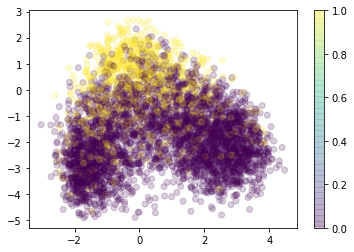

In [340]:
_ = plt.scatter(pca_2comps['PCA1'], pca_2comps['PCA2'],c = pca_2comps['y'],alpha=0.2)
plt.colorbar() #  1 'Never' & 0 is 'Always' + 'Sporadic'
plt.show()

The best 2 principal components do a decent job of separating nonvoters from others.

In [341]:
print(X_train.shape)
print(components.shape)

(4668, 294)
(293, 294)


In [342]:
pca_train = pd.DataFrame()
for i in range(132):
    pca_train['pca_'+str(i+1)] = np.dot(X_train,components[i])

# apply new PCA to X_test

pca_test = pd.DataFrame()
for i in range(132):
    pca_test['pca_'+str(i+1)] = np.dot(X_test,components[i])

In [343]:
pca_train.shape

(4668, 132)

Clustering with PCA features

In [344]:
# create total PCA matrix with all rows of original survey

#pca_total = pd.concat([pca_train,pca_test])
pca_X = PCA(n_components='mle')
pca_X.fit(X)
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)
print(pca.n_components_)

293


In [345]:
# determine the cumulative explained variance and at what number
# component it occurs
index = []
cumulative = []
perc = 0
for i, p in enumerate(pca_X.explained_variance_ratio_):
    perc += p
    cumulative.append((i,perc))
for comp in cumulative:
    if comp[1]>0.90:
        print(comp)
        break

(132, 0.9004537576890981)


In [346]:
components = pca_X.components_
pca_total = pd.DataFrame()
for i in range(132):
    pca_total['pca_'+str(i+1)] = np.dot(X,components[i])
print(pca_total.shape)
print(pca_total.head())

(5836, 132)
      pca_1     pca_2     pca_3     pca_4     pca_5     pca_6     pca_7  \
0  3.192404 -2.273049 -2.330000 -2.101546  0.668754 -1.471969 -0.859986   
1 -0.500245 -0.876130 -3.563671 -1.459821 -1.315648  0.510855 -1.071887   
2  1.870970 -1.124001 -3.101672 -0.917114  0.975886  0.963398  0.732553   
3  2.473247 -2.409641 -2.632638  0.284734 -0.534824 -0.640993  0.242272   
4 -1.922623 -3.895795 -0.419600 -1.324026 -2.049386  0.011465 -1.433452   

      pca_8     pca_9    pca_10  ...   pca_123   pca_124   pca_125   pca_126  \
0 -0.303808  0.530934  0.456856  ...  0.002559  0.974809  0.684744  0.476757   
1 -1.039125 -0.211308  0.160212  ...  0.238691  0.907783  0.147497 -0.013479   
2 -0.531401  0.611555  0.961399  ... -0.517972  0.347467  0.605226  0.215552   
3 -2.468324 -0.251593  0.304707  ... -0.348221  0.333603  0.817343  0.306605   
4 -1.500961  0.399606  1.053885  ... -0.238691  0.459540  0.679763  0.874006   

    pca_127   pca_128   pca_129   pca_130   pca_131   pc

In [347]:
# define how much of pca_total to use for clustering
cols_number = 10
type(pca_total.iloc[:,0:cols_number])

pandas.core.frame.DataFrame

In [348]:
x_cols = pca_total.iloc[:,0:cols_number].to_numpy()
ss_means = []
k_list = []
for k in range(3,10): 
    ss = []
    k_list.append(k)
    for run in range(3):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit_predict(x_cols)
        ss.append(kmeans.inertia_)
    ss_means.append(np.mean(ss))
print(x_cols.shape)
print(k_list,ss_means)
                                         

(5836, 10)
[3, 4, 5, 6, 7, 8, 9] [43578.90046219806, 40543.46948469748, 38047.656058958324, 36588.07143451472, 35279.085151627696, 34119.32578720119, 33079.55626328197]


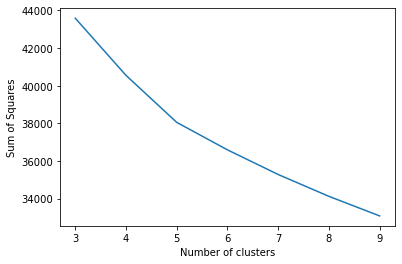

In [349]:
_ = plt.plot(k_list,ss_means)
_ = plt.xlabel('Number of clusters')
_ = plt.ylabel('Sum of Squares')
plt.show()

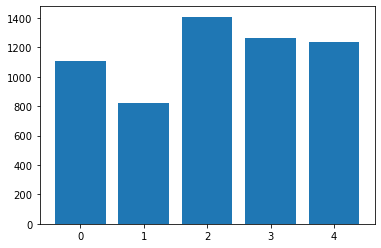

In [350]:
kmeans = KMeans(n_clusters=5)
kmeans.fit_predict(x_cols)

labels = kmeans.labels_
unique, counts = np.unique(labels, return_counts=True)
_ = plt.bar(unique, counts)
plt.show()

In [351]:
silhouette_score(x_cols, labels)

0.15428236222734334

The silhouette_score improve from about 0.03 to 0.15 with the use of PCA and keeping only 10 columns (to reduce dimensionality).

Assess how well clustering works on PCA data. (1) Characterize the clusters as above by identifying the most important features in each cluster (2) Visualize each cluster by plotting the first two PCA columns as x and y and coloring with cluster labels

In [352]:
pca_df = pd.DataFrame({'x':pca_total['pca_1'],'y':pca_total['pca_2']
                       ,'kmeans label':labels,'voter category':df_corr['voter_category']
                      ,'voter code':df_corr['voter code']})

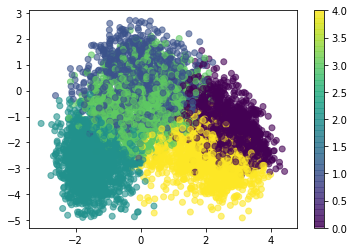

In [353]:
plt.scatter(pca_df['x'],pca_df['y'],c=pca_df['kmeans label'],alpha=.6)
plt.colorbar()
plt.show()

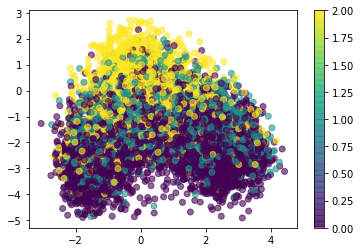

In [354]:
plt.scatter(pca_df['x'],pca_df['y'],c=pca_df['voter code'],alpha=.6)
plt.colorbar()
plt.show()

In [355]:
df_labels = df_corr_dum.copy()
df_labels['labels']=labels
df_summary = df_labels.groupby('labels').mean()
df_summary['voter_category_always'] = 1-df_summary['voter_category_rarely/never']-df_summary['voter_category_sporadic']
df_summary

Q2_1_1    Q2_1_2    Q2_1_3    Q2_1_4    Q2_2_1    Q2_2_2    Q2_2_3  \
labels                                                                         
0       0.913122  0.074208  0.007240  0.003620  0.397285  0.466063  0.101357   
1       0.291616  0.380316  0.132442  0.173755  0.132442  0.377886  0.274605   
2       0.952415  0.036932  0.003551  0.002841  0.642756  0.277699  0.055398   
3       0.759303  0.218527  0.015044  0.003959  0.361837  0.477435  0.132225   
4       0.977365  0.012126  0.003234  0.003234  0.728375  0.200485  0.049313   

          Q2_2_4    Q2_3_1    Q2_3_2  ...  income_cat_$75-125k  \
labels                                ...                        
0       0.034389  0.470588  0.485068  ...             0.323077   
1       0.199271  0.145808  0.428919  ...             0.166464   
2       0.018466  0.634943  0.318182  ...             0.296875   
3       0.022961  0.235154  0.652415  ...             0.300079   
4       0.016168  0.760711  0.208569  ...             0.272433   

        income_cat_Less than $40k  voter_category_rarely/never  \
labels                                                           
0                        0.158371                     0.110407   
1                        0.482382                     0.699878   
2                        0.177557                     0.086648   
3                        0.229612                     0.224861   
4                        0.247373                     0.054163   

        voter_category_sporadic  age_26-35  age_36-45  age_46-55  age_56-65  \
labels                                                                        
0                      0.280543   0.348416   0.185520   0.121267   0.155656   
1                      0.155529   0.349939   0.226002   0.140948   0.143378   
2                      0.144886   0.095881   0.105114   0.170455   0.246449   
3                      0.285036   0.158353   0.180523   0.181314   0.228820   
4                      0.134196   0.054972   0.063864   0.138238   0.283751   

         age_66+  voter_category_always  
labels                                   
0       0.101357               0.609050  
1       0.059538               0.144593  
2       0.349432               0.768466  
3       0.193983               0.490103  
4       0.441390               0.811641  

[5 rows x 297 columns]

In [356]:
question=[]
cluster=[]
strength_over_mean=[]
strength_over_2=[]
for col in df_summary.columns:
    if df_summary[col].max()/df_summary[col].mean()>1.5:
        question.append(col)
        cluster.append(df_summary[col].idxmax())
        strength_over_mean.append(df_summary[col].max()/df_summary[col].mean())     
        strength_over_2.append(df_summary[col].max()/df_summary[col].quantile(0.75))     

# create summary dataframe from lists 
cluster_summary=pd.DataFrame({'Question':question,'Cluster':cluster,
                              'Strength Over Mean':strength_over_mean,
                              'Strength Over 2nd Best':strength_over_2})

In [357]:
for cluster in [0,1,2,3,4]:
    print(cluster_summary[cluster_summary['Cluster']==cluster].sort_values('Strength Over 2nd Best',ascending=False).head(5))

    Question  Cluster  Strength Over Mean  Strength Over 2nd Best
26    Q2_9_4        0            2.573959                2.798643
140  Q18_6_1        0            2.213323                2.580970
12    Q2_4_4        0            2.673970                2.031639
17    Q2_6_3        0            2.247168                1.827721
141  Q18_7_1        0            2.202594                1.810877
      Question  Cluster  Strength Over Mean  Strength Over 2nd Best
2       Q2_1_4        1            4.635734               43.890401
9       Q2_3_4        1            4.206206               17.678412
181  Q29_9_1.0        1            4.388569               13.428007
15      Q2_5_4        1            4.269099               10.001682
154    Q22_2.0        1            4.349182                8.900851
    Question  Cluster  Strength Over Mean  Strength Over 2nd Best
68    Q8_1_1        2            3.771651                7.569211
186  Q31_1.0        2            4.009405                5.94365

## 4.8 Random Forest  with PCA features<a id='4.8_PCA_RF'></a>

In [358]:
# Randomized hyperparameter tuning
# check if tuning needs to run
if run_tuning:

    # Use the random grid to search for best hyperparameters
    rf = RandomForestClassifier()
    # Random search of parameters, using 5 fold cross validation, 
    # search across 100 different combinations
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='roc_auc', n_iter = 100, cv = 5, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(pca_train,y_train)
    rf_random.best_params_

In [359]:
# Run Random Forests on pca_train with y_train as label

clf = RandomForestClassifier(n_estimators=320,
                             min_samples_split= 5,
                             min_samples_leaf= 5,
                             max_features= 'sqrt',
                             class_weight= 'balanced',
                             bootstrap= False,                             
                             max_depth = 5,
                             random_state = 123, 
                             n_jobs=-1)

# train model, 
model_res, y_pred, y_pred_prob, lr_probs, ac, prec, rec, cm, train_ac, train_rec, train_prec = RF_model_results(clf, pca_train, pca_test, y_train, y_test)


Random Forest: Test Accuracy=0.850
Random Forest: Test Precision=0.598
Random Forest: Test Recall=0.690
[[837 105]
 [ 70 156]]
Random Forest: Train Accuracy=0.904
Random Forest: Train Precision=0.727
Random Forest: Train Recall=0.839


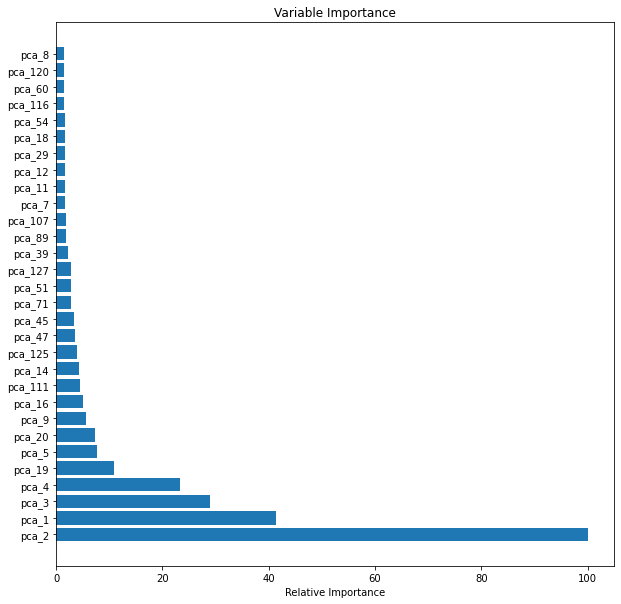

In [360]:
feature_importance(clf, pca_train)

Random Forest using PCA features did not improve predictions.
Now try again using all original X features plus five cluster labels plus PCA features.

## 4.9 Random Forest  with X + cluster labels + PCA features<a id='4.9_RF_PCA_clusters'></a>

In [361]:
print(X_train.shape)
print(pca_train.shape)
print(X_test.shape)
print(pca_test.shape)

(4668, 294)
(4668, 132)
(1168, 294)
(1168, 132)


In [362]:
Xl = pd.concat([X_train,X_test],axis=0)
pca_concat = pd.concat([pca_train,pca_test],axis=0)

In [363]:
pca_concat.head()

pca_1     pca_2     pca_3     pca_4     pca_5     pca_6     pca_7  \
0  2.191151 -2.712642 -0.671297 -0.690528  1.768652 -0.079805 -0.600250   
1 -0.461644 -2.788528 -1.391971  0.496780  0.161284  0.307431 -1.086345   
2 -1.132413 -1.054170 -2.262448 -2.140454  0.838027  0.268475  0.384954   
3 -0.327916 -0.747506 -1.685349  1.517599  0.978162  0.773592 -1.831116   
4  0.416973 -1.757170 -3.798863  0.324124  0.777565  0.028611  0.435479   

      pca_8     pca_9    pca_10  ...   pca_123   pca_124   pca_125   pca_126  \
0 -2.044342  0.730549 -1.695203  ...  0.264379  0.309272 -0.590117  0.907371   
1 -0.344041  0.902228  0.318950  ... -0.014116  0.826330 -0.232596  0.580322   
2 -0.382454 -0.080829 -0.792571  ...  0.368385  0.856456 -1.017878  0.682202   
3 -0.380073  0.809337 -0.035149  ... -0.467903  0.459452 -0.600376  0.296630   
4 -1.085747  0.455992 -1.172186  ...  0.221218  0.864539 -0.351527  0.330324   

    pca_127   pca_128   pca_129   pca_130   pca_131   pca_132  
0 -0.074707 -1.108066 -0.200793  0.049523 -0.001176  0.094897  
1 -0.210624 -1.388862  0.192076 -0.197415  0.503114  0.308393  
2  0.540371 -1.282072 -0.615739  0.358851  0.858769 -0.571901  
3  0.568113 -0.733657 -0.582428 -0.091217  0.406602 -0.886023  
4  0.044847 -0.874492 -0.135988  0.261420  0.140458 -0.227735  

[5 rows x 132 columns]

In [364]:
for col in pca_concat.columns:
    Xl[col] = pca_concat[col].to_numpy()

In [365]:
Xl['labels']=labels
Xl.shape

(5836, 427)

In [366]:
df_labels_pca = pd.concat([Xl,y],axis=1)

In [367]:
Xl = df_labels_pca.drop('voter_category_rarely/never', axis=1)
y = df_labels_pca['voter_category_rarely/never']
Xl_train, Xl_test, yl_train, yl_test = train_test_split(Xl, y, test_size=0.2, random_state=123)


In [368]:
# Randomized hyperparameter tuning
# check if tuning needs to run
if run_tuning:

    # Use the random grid to search for best hyperparameters
    rf = RandomForestClassifier()
    # Random search of parameters, using 5 fold cross validation, 
    # search across 100 different combinations
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='roc_auc', n_iter = 50, cv = 5, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train,y_train)
    rf_random.best_params_

In [369]:
clf = RandomForestClassifier(n_estimators=200,
                             min_samples_split= 10,
                             min_samples_leaf=5,
                             max_features='sqrt',
                             max_depth = 3,
                             class_weight='balanced_subsample',
                             bootstrap=False,
                             random_state = 123, 
                             n_jobs=-1)

In [370]:
model_res, y_pred, y_pred_prob, lr_probs, ac, prec, rec, cm, train_ac, train_rec, train_prec = RF_model_results(clf, Xl_train, Xl_test, yl_train, yl_test)

Random Forest: Test Accuracy=0.872
Random Forest: Test Precision=0.684
Random Forest: Test Recall=0.681
[[859  74]
 [ 75 160]]
Random Forest: Train Accuracy=0.886
Random Forest: Train Precision=0.700
Random Forest: Train Recall=0.754


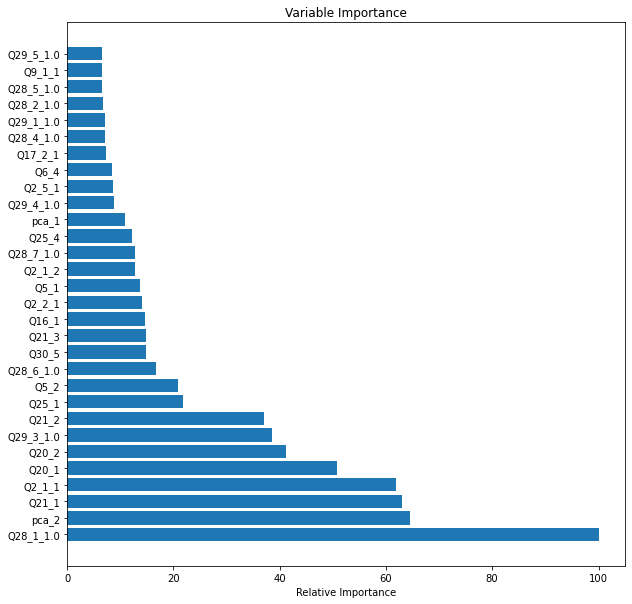

In [371]:
feature_importance(clf, Xl)

Including all of the pca features and labels did not improve predictions.

## 4.10 Logistic Regression Classifier<a id='4.10_logistic_regression'></a>


In [372]:
for col in df_corr_dum:
    if 'Q27_' in col:
        print(col)

In [373]:
tol = [0.0001,0.001,0.01]
C = [0.5,1,2]
fit_intercept = [True,False]
class_weight = [None, 'balanced']
solver = ['newton-cg', 'lbfgs', 'liblinear']
max_iter = [20,100,200]
verbose = [0,1,2]
warm_start = [True,False]

random_grid_lr = {'tol':tol,
              'C':C,
              'fit_intercept':fit_intercept,
              'class_weight':class_weight,
              'solver':solver,
              'max_iter':max_iter,
              'verbose':verbose,
              'warm_start':warm_start}

In [374]:
run_tuning = True

In [375]:
# check if tuning needs to run
if run_tuning:

    # Use the random grid to search for best hyperparameters
    lrc = LogisticRegression()
    # Random search of parameters, using 5 fold cross validation, 
    # search across 200 different combinations
    lrc_random = RandomizedSearchCV(estimator = lrc, param_distributions = random_grid_lr, scoring='recall', n_iter = 200, cv = 5, random_state=42, n_jobs = -1)
    # Fit the random search model
    lrc_random.fit(X_train,y_train)
    lrc_random.best_params_

In [376]:
lrc_random.best_params_

{'warm_start': True,
 'verbose': 0,
 'tol': 0.0001,
 'solver': 'newton-cg',
 'max_iter': 200,
 'fit_intercept': True,
 'class_weight': 'balanced',
 'C': 0.5}

In [377]:
# X data is just original survey features
lrc = LogisticRegression(
    warm_start=True,
     verbose=0,
     tol=0.0001,
     solver='newton-cg',
     max_iter=20,
     fit_intercept=True,
     class_weight='balanced',
     C=0.5,
    random_state=123)
model_res, y_pred, y_pred_prob, lr_probs, ac, prec, rec, cm, train_ac, train_rec, train_prec = RF_model_results(lrc, X_train, X_test, y_train, y_test)

Random Forest: Test Accuracy=0.884
Random Forest: Test Precision=0.664
Random Forest: Test Recall=0.814
[[849  93]
 [ 42 184]]
Random Forest: Train Accuracy=0.904
Random Forest: Train Precision=0.714
Random Forest: Train Recall=0.880


In [378]:
# X data is original data + PCA features + cluster labels

# check if tuning needs to run
if run_tuning:
    # Use the random grid to search for best hyperparameters
    lrc = LogisticRegression()
    # Random search of parameters, using 5 fold cross validation, 
    # search across 200 different combinations
    lrc_random = RandomizedSearchCV(estimator = lrc, param_distributions = random_grid_lr, scoring='recall', n_iter = 200, cv = 5, random_state=42, n_jobs = -1)
    # Fit the random search model
    lrc_random.fit(Xl_train,yl_train)
    lrc_random.best_params_

In [379]:
lrc_random.best_params_

{'warm_start': True,
 'verbose': 0,
 'tol': 0.0001,
 'solver': 'newton-cg',
 'max_iter': 200,
 'fit_intercept': True,
 'class_weight': 'balanced',
 'C': 0.5}

In [380]:
lrc = LogisticRegression(
    warm_start=True,
     verbose=0,
     tol=0.0001,
     solver='newton-cg',
     max_iter=200,
     fit_intercept=True,
     class_weight='balanced',
     C=0.5,
    random_state=123)

model_res, y_pred, y_pred_prob, lr_probs, ac, prec, rec, cm, train_ac, train_rec, train_prec = RF_model_results(lrc, Xl_train, Xl_test, yl_train, yl_test)

Random Forest: Test Accuracy=0.882
Random Forest: Test Precision=0.684
Random Forest: Test Recall=0.766
[[850  83]
 [ 55 180]]
Random Forest: Train Accuracy=0.905
Random Forest: Train Precision=0.710
Random Forest: Train Recall=0.888


In [381]:
# X data is PCA features

# check if tuning needs to run
if run_tuning:
    
    # Use the random grid to search for best hyperparameters
    lrc = LogisticRegression()
    # Random search of parameters, using 5 fold cross validation, 
    # search across 200 different combinations
    lrc_random = RandomizedSearchCV(estimator = lrc, param_distributions = random_grid_lr, scoring='recall', n_iter = 200, cv = 5, random_state=42, n_jobs = -1)
    # Fit the random search model
    lrc_random.fit(pca_train,y_train)
    lrc_random.best_params_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Drew\miniconda3\envs\dsmin\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [382]:
lrc_random.best_params_

{'warm_start': False,
 'verbose': 1,
 'tol': 0.001,
 'solver': 'lbfgs',
 'max_iter': 20,
 'fit_intercept': True,
 'class_weight': 'balanced',
 'C': 0.5}

In [384]:
# change max_iter to 200 to avoid nonconvergence
lrc = LogisticRegression(
    warm_start=False,
     verbose=1,
     tol=0.001,
     solver='lbfgs',
     max_iter=200,
     fit_intercept=True,
     class_weight='balanced',
     C=0.5,
    random_state=123)

model_res, y_pred, y_pred_prob, lr_probs, ac, prec, rec, cm, train_ac, train_rec, train_prec = RF_model_results(lrc, pca_train, pca_test, y_train, y_test)


Random Forest: Test Accuracy=0.869
Random Forest: Test Precision=0.632
Random Forest: Test Recall=0.774
[[840 102]
 [ 51 175]]
Random Forest: Train Accuracy=0.882
Random Forest: Train Precision=0.662
Random Forest: Train Recall=0.856


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


All of the logistic regression models suffered from either poor precision or poor recall as well as from overfitting. The random forest model seems to do a better job with balancing precision and recall.